# Spatial Visualization

Spatially visualize the results from the script Fra_XeniumAnalysis_**.ipynb.   
conda env: r-4.4.2

In [1]:
library(Seurat)
library(future)
library(dplyr)
library(scales) # color palette: hue_pal()
library(ggplot2)
library(tibble)
library(ggrepel)
library(Polychrome)

set.seed(49)

# Function for setting the size of figures in the notebook
figsize <- function(width, height) {
    options(repr.plot.width = width, repr.plot.height = height)
}

Warning message:
“package ‘Seurat’ was built under R version 4.4.2”
Loading required package: SeuratObject

Warning message:
“package ‘SeuratObject’ was built under R version 4.4.2”
Loading required package: sp


Attaching package: ‘SeuratObject’


The following objects are masked from ‘package:base’:

    intersect, t



Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [2]:
dir = "/staging/leuven/stg_00080/vrc/Projects/Project_Heesoo/spatial_datasets/Xenium5k_NSCLC"
figdir = "/staging/leuven/stg_00080/vrc/Projects/Project_Heesoo/PhD-Project/2025_Francesca_PanCancer/figures"

In [3]:
obj <- LoadSeuratRds(paste0(dir, "/xenium5k_NSCLC_obj_singlets.rds"))
obj_EC <- LoadSeuratRds(file.path(dir, "EC_query.rds"))
obj_MM <- LoadSeuratRds(file.path(dir, "MM_query.rds"))
obj_TC <- LoadSeuratRds(file.path(dir, "TC_query.rds"))
obj_BC <- LoadSeuratRds(file.path(dir, "BC_query.rds"))
obj_DC <- LoadSeuratRds(file.path(dir, "DC_query.rds"))

# Test if cells match (must be all 0)
length(setdiff(Cells(obj)[obj$RCTD.predicted_celltype == "EC"], Cells(obj_EC)))
length(setdiff(Cells(obj)[obj$RCTD.predicted_celltype == "Macro-Mono"], Cells(obj_MM)))
length(setdiff(Cells(obj)[obj$RCTD.predicted_celltype == "T cell"], Cells(obj_TC)))
length(setdiff(Cells(obj)[obj$RCTD.predicted_celltype == "B cell"], Cells(obj_BC)))
length(setdiff(Cells(obj)[obj$RCTD.predicted_celltype == "DC"], Cells(obj_DC)))

[1] 0

[1] 0

[1] 0

[1] 0

[1] 0

In [4]:
# Transfer subcluster annotation to obj
unique(obj$RCTD.predicted_celltype)
obj$celltype_detail <- as.character(obj$RCTD.predicted_celltype)
obj$celltype_detail[Cells(obj_EC)] <- as.character(obj_EC$predicted.celltype)
obj$celltype_detail[Cells(obj_TC)] <- as.character(obj_TC$predicted.celltype)
obj$celltype_detail[Cells(obj_BC)] <- as.character(obj_BC$predicted.celltype)
obj$celltype_detail[Cells(obj_DC)] <- as.character(obj_DC$predicted.celltype)
obj$celltype_detail[Cells(obj_MM)] <- as.character(obj_MM$predicted.celltype)

[1] NK                T cell            B cell            Cancer-epithelial
[5] Fibroblast        Macro-Mono        DC                EC               
[9] Mast cell        
9 Levels: T cell NK B cell Macro-Mono DC Mast cell ... EC

In [5]:
# Merge annotations for a few cell types (marker gene expression heatmap does not show significant differences)
obj$celltype_detail[obj$celltype_detail %in% c("mQuiescDC", "mRegDC")] <- "Mig DC"
obj$celltype_detail[obj$celltype_detail %in% c("IgA immature", "IgA mature")] <- "IgA"
obj$celltype_detail[obj$celltype_detail %in% c("IgG immature", "IgG mature")] <- "IgG"

# Rename cell types
obj$celltype_detail[obj$celltype_detail == "Proliferating"] <- "Prolif T"
obj$celltype_detail[obj$celltype_detail == "AXL_DC"] <- "AXL DC"
obj$celltype_detail <- factor(obj$celltype_detail)

In [6]:
# Major cell types distinguishing Alveolar cells
obj$celltype_major <- as.character(obj$RCTD.predicted_celltype)
obj$celltype_major[obj$celltype_detail == "Alveolar"] <- "Cancer-epithelial"
obj$celltype_major <- factor(obj$celltype_major, levels = c("T cell", "NK", "B cell", "Macro-Mono", "DC", "Mast cell", "EC", "Fibroblast", "Cancer-epithelial"))

In [7]:
obj
obj@images$fov

An object of class Seurat 
10002 features across 175567 samples within 2 assays 
Active assay: Xenium (5001 features, 2991 variable features)
 3 layers present: counts, data, scale.data
 1 other assay present: RNA
 3 dimensional reductions calculated: spatial, pca, umap
 1 spatial field of view present: fov

Spatial coordinates for 175567 cells
Default segmentation boundary: centroids 
Associated assay: Spatial 
Key: Spatial_ 

Warning message:
“No FOV associated with assay 'Xenium', using global default FOV”
Warning message:
“No FOV associated with assay 'Xenium', using global default FOV”


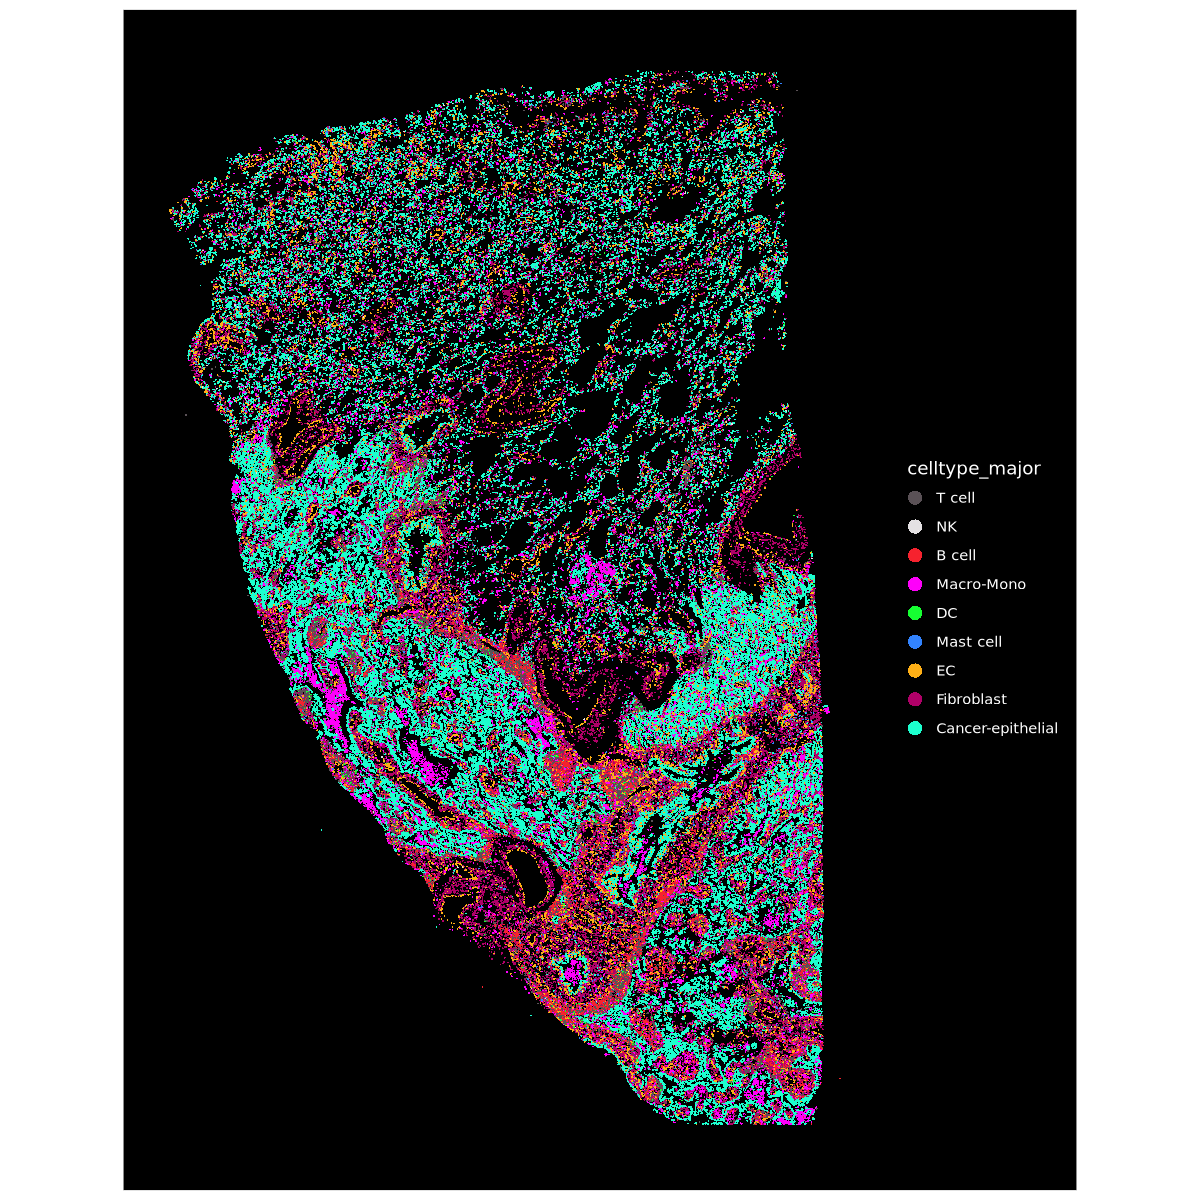

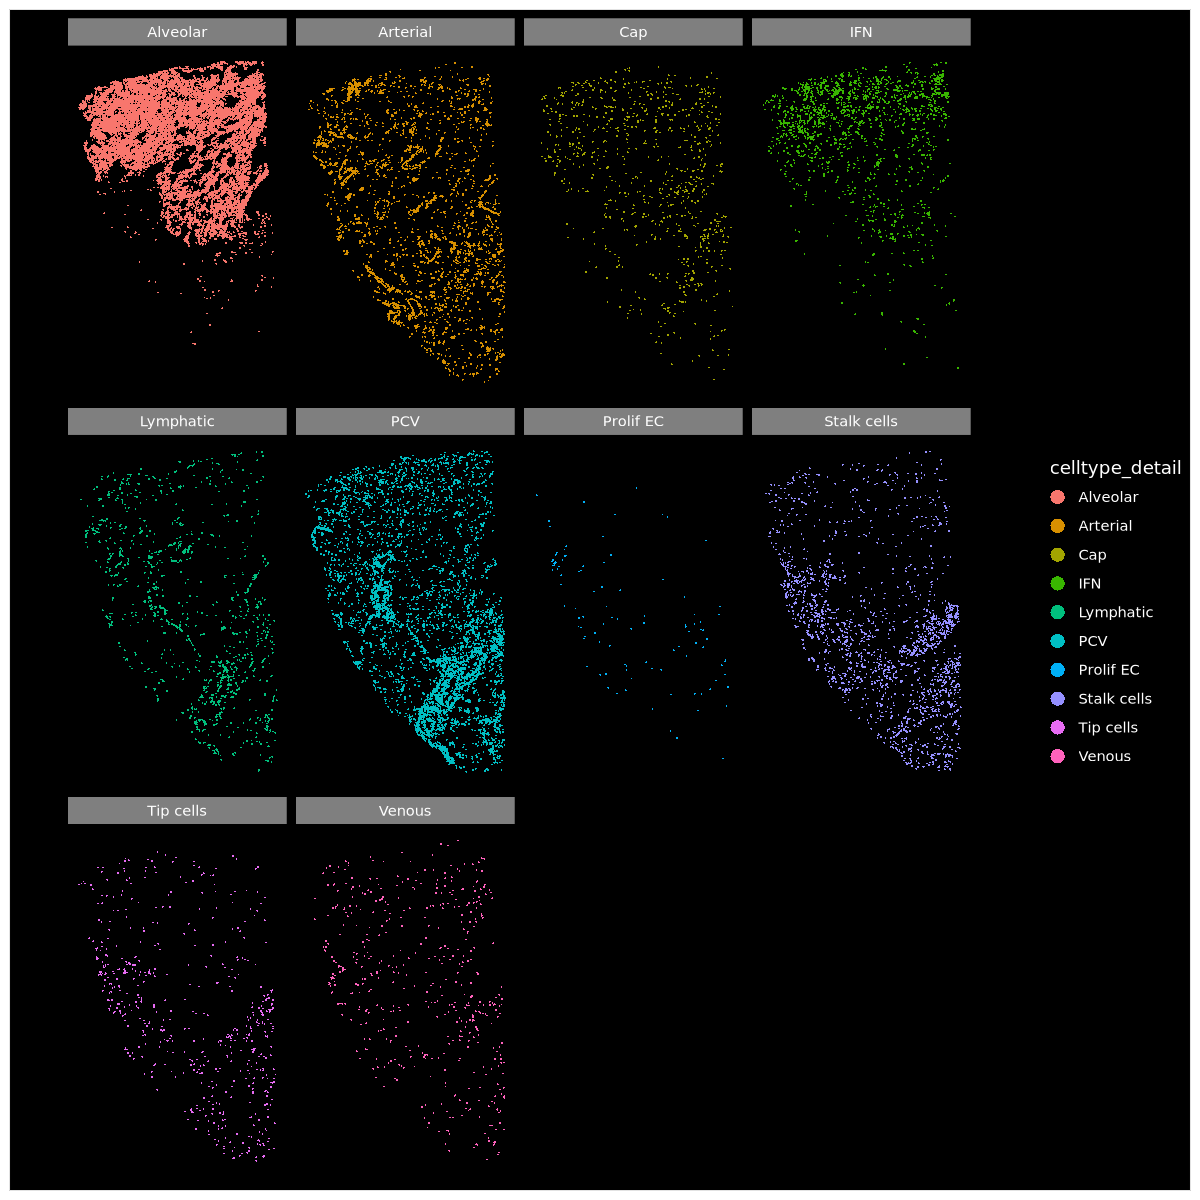

In [8]:
figsize(10, 10)
ImageDimPlot(obj, group.by = "celltype_major", cols = "polychrome")
ImageDimPlot(obj, group.by = "celltype_detail", split.by = "celltype_detail", cells = Cells(obj)[obj$RCTD.predicted_celltype == "EC"])

## Module-specific cell types and features

In [ ]:
TLS_celltypes <- c("CD4+ TFH", "Memory GC-indep", "Breg", "Plasmablast", "IFN Mac", "IgG", "IgA", "Mig DC", "PCV")
ImActive_celltypes <- c("CD4+ TREG", "Mig DC", "Mono-like Mac", "LAM2", "Neutrophils", "AXL DC", "Inflam Mac", 
                "Lymphatic", "CD4+ TH1", "CD8+ TEX", "Prolif T")

TLS_module_genes_list <- list(`CD4+ TFH` = c("CXCL13", "KLRB1", "NR3C1", "SRGN", "TNFRSF4", "NMB", "ITM2A", "FKBP5", "TNFRSF18", "SPOCK2"), 
                                `GC indep` = c("MS4A1", "CD79A", "CD79B", "TCL1A", "VPREB3", "LRMP", "RGS13", "CD22", "HLA-DQA1", "IRF8"),
                                `Breg` = c("MS4A1", "CD79A", "CD74", "BANK1", "HLA-DQA1", "HLA-DRA", "CD37", "HLA-DQB1", "HLA-DPB1", "HLA-DPA1"),
                                Plasmablast = c("IGLC3", "MZB1", "IGHM", "IGHG1", "IGHG3", "IGHG2", "JCHAIN", "IGKV4-1", "IGKC", "IGLC2"),
                                `IFN Mac` = c("CXCL10", "CXCL9", "LYZ", "C1QB", "C1QC", "C1QA", "HLA-DRA", "HLA-DQA1", "HLA-DRB1", "CALHM6"),
                                IgG = c("IGLV6-57", "IGKV3-20", "IGLV3-1", "IGHG3", "IGKV4-1", "IGLC3", "IGLC2", "IGHG1", "IGHG4", "IGKC", "IGHG2", "IGHGP"),
                                IgA = c("IGHA1", "JCHAIN", "IGKC", "IGHA2", "MS4A1", "CD79A", "MZB1", "BANK1", "DERL3", "CD37", "IGHM", "IGLC3", "IGLC2", "IGLV3-1", "IGLL5"),
                                mQuiescDC = c("FSCN1", "HLA-DPB1", "HLA-DQA1", "HLA-DRA", "HLA-DPA1", "CCL19", "CD74", "IDO1", "HLA-DQB1", "LSP1"))
                                
ImActive_module_genes_list <- list(`CD4+ TREG` = c("TNFRSF4", "FOXP3", "IL32", "TNFRSF18", "LTB", "BATF", "CTLA4", "IL2RA", "TIGIT", "CD27"),
                                    mRegDC = c("CCL22", "CCL17", "FSCN1", "BIRC3", "CCL19", "LAMP3", "CCR7", "TXN", "CD83", "CDKN1A"),
                                    `Mono-like Mac` = c("LYZ", "AIF1", "TYROBP", "IL1B", "FCN1", "FCER1G", "C15orf48", "HLA-DRA", "S100A9", "LST1"),
                                    LAM2 = c("SPP1", "MMP12", "MMP9", "FBP1", "CSTB", "CTSB", "IL1RN", "CD68", "LYZ", "TYROBP"),
                                    Neutrophils = c("CXCL8", "G0S2", "IL1B", "CCL3L1", "BCL2A1", "PLEK", "CCL4L2", "IL1RN", "HCAR2", "NAMPT"),
                                    AXL_DC = c("CCL17", "C15orf48", "HLA-DRA", "MMP12", "HLA-DPB1", "HLA-DQA1", "HLA-DPA1", "HLA-DQB1", "HLA-DRB1", "CCL22"),
                                    `Inflam Mac` = c("IL1B", "CCL3", "CXCL3", "CXCL8", "CCL3L1", "CCL20", "CXCL2", "PLAUR", "G0S2", "C15orf48"),
                                    Lymphatic = c("CCL21", "MMRN1", "EFEMP1", "TFPI", "FABP4", "GNG11", "CLDN5", "RAMP2", "IGFBP7", "CAVIN2"),
                                    `CD4+ TH1` = c("CXCL13", "TNFRSF18", "CCL4", "IFNG", "CD2", "PDCD1", "CD3D", "DUSP4", "LAG3", "TNFRSF4"),
                                    `CD8+ TEX` = c("GZMB", "CXCL13", "GNLY", "CCL5", "CCL4L2", "CCL4", "GZMA", "NKG7", "LAG3", "CD8A"),
                                    `Prolif Tcell` = c("HMGB2", "HIST1H4C", "GZMB", "STMN1", "CXCL13", "MKI67", "GZMA", "TUBA1B", "GNLY", "TUBB"))

In [8]:
# TLS signature genes
as.character(unlist(TLS_module_genes_list))[as.character(unlist(TLS_module_genes_list)) %in% rownames(obj)] %>% unique()

# Type1 immunity signature genes
as.character(unlist(ImActive_module_genes_list))[as.character(unlist(ImActive_module_genes_list)) %in% rownames(obj)] %>% unique()

[1] "CXCL13"   "KLRB1"    "NR3C1"    "NMB"      "ITM2A"    "TNFRSF18"
 [7] "MS4A1"    "CD79A"    "CD79B"    "TCL1A"    "CD22"     "IRF8"    
[13] "BANK1"    "MZB1"     "CXCL10"   "CXCL9"    "DERL3"    "FSCN1"   
[19] "CCL19"    "IDO1"

[1] "FOXP3"    "TNFRSF18" "BATF"     "CTLA4"    "IL2RA"    "TIGIT"   
 [7] "CD27"     "CCL22"    "CCL17"    "FSCN1"    "CCL19"    "LAMP3"   
[13] "CCR7"     "CD83"     "CDKN1A"   "IL1B"     "FCN1"     "MMP12"   
[19] "MMP9"     "FBP1"     "IL1RN"    "CD68"     "BCL2A1"   "HCAR2"   
[25] "CCL20"    "CXCL2"    "PLAUR"    "TFPI"     "CLDN5"    "CAVIN2"  
[31] "CXCL13"   "IFNG"     "CD2"      "PDCD1"    "LAG3"     "GZMB"    
[37] "GZMA"     "CD8A"     "HMGB2"    "STMN1"    "MKI67"    "TUBB"

## Grid analysis

In [21]:
# Create grid matrix

grid_size <- 100

cell_coordinates <- GetTissueCoordinates(obj)
cell_coordinates$cell_id <- obj$cell_id
cell_coordinates$celltype_major <- obj$RCTD.predicted_celltype
cell_coordinates$celltype_detail <- obj$celltype_detail

grid_xmin <- seq(from = 0, to = max(cell_coordinates$x), by = grid_size)
grid_ymin <- seq(from = 0, to = max(cell_coordinates$y), by = grid_size)
grid_coordinates <- expand.grid(grid_xmin = grid_xmin, grid_ymin = grid_ymin)
grid_coordinates$grid_xmax <- grid_coordinates$grid_xmin + grid_size
grid_coordinates$grid_ymax <- grid_coordinates$grid_ymin + grid_size
grid_coordinates$gridcentroid_x <- grid_coordinates$grid_xmin + grid_size/2
grid_coordinates$gridcentroid_y <- grid_coordinates$grid_ymin + grid_size/2
grid_coordinates$grid_id <- paste0("grid_", rownames(grid_coordinates))
rownames(grid_coordinates) <- grid_coordinates$grid_id

print(paste0("number of grids: ", as.character(dim(grid_coordinates)[1])))
print(paste0("number of cells: ", length(cell_coordinates$cell_id)))

[1] "number of grids: 8625"
[1] "number of cells: 175567"


In [22]:
# Assign cells in each grid

merged_df <- cell_coordinates %>%
  rowwise() %>%
  mutate(
    grid_id = grid_coordinates$grid_id[
      which(
        x >= grid_coordinates$grid_xmin & x < grid_coordinates$grid_xmax &
        y >= grid_coordinates$grid_ymin & y < grid_coordinates$grid_ymax
      )
    ][1]
  ) %>%
  left_join(grid_coordinates, by = "grid_id") %>%
  relocate(grid_id, cell_id, .before = everything()) %>% 
  arrange(grid_id)

saveRDS(merged_df, file = paste0(dir, "/grid_cell_matrix.rds"))
print(dim(merged_df))
head(merged_df)

[1] 175567     13


grid_id,cell_id,x,y,cell,celltype_major,celltype_detail,grid_xmin,grid_ymin,grid_xmax,grid_ymax,gridcentroid_x,gridcentroid_y
<chr>,<chr>,<dbl>,<dbl>,<chr>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
grid_1000,bojcojbh-1,7921.078,887.6525,cell_36562,EC,Alveolar,7900,800,8000,900,7950,850
grid_1000,odagpeke-1,7911.829,835.5196,cell_271607,EC,Cap,7900,800,8000,900,7950,850
grid_1000,odahcmgi-1,7900.797,834.7857,cell_271608,Macro-Mono,Perivasc Mac,7900,800,8000,900,7950,850
grid_1000,odahdacl-1,7915.776,840.4528,cell_271609,Macro-Mono,Hypoxic Mac,7900,800,8000,900,7950,850
grid_1000,odajgogl-1,7909.771,858.0430,cell_271621,EC,Alveolar,7900,800,8000,900,7950,850
grid_1000,odajpjga-1,7917.126,894.4576,cell_271623,Mast cell,Mast cell,7900,800,8000,900,7950,850


In [52]:
#Create an expression matrix by grid - Just sum the counts so that it reflects the nCells in each grid

expr_df <- as.data.frame(as.matrix(GetAssayData(obj)))
expr_df <- tibble::rownames_to_column(expr_df, var = "gene")
expr_df <- tidyr::pivot_longer(expr_df, cols = -gene, names_to = "cell", values_to = "expression")

expr_grid <- expr_df %>%
  left_join(merged_df, by = "cell") %>%
  group_by(gene, grid_id) %>%
  summarise(expression_sum = sum(expression, na.rm = TRUE), .groups = "drop")

expr_grid <- tidyr::pivot_wider(expr_grid, names_from = grid_id, values_from = expression_sum, values_fill = 0)
expr_grid <- tibble::column_to_rownames(expr_grid, var = "gene")

Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 6.7 GiB”


In [53]:
# Update grid_coordinates - only include grids with at least one cell
grid_coordinates <- grid_coordinates[grid_coordinates$grid_id %in% colnames(expr_grid), ]
obj_grid <- CreateSeuratObject(expr_grid, meta.data = grid_coordinates)

# Create a new seurat object with grids
dim_grid <- grid_coordinates[,c("gridcentroid_x", "gridcentroid_y")]
colnames(dim_grid) <- c("gridcentroid_1", "gridcentroid_2")
obj_grid[["gridcentroid"]] <- CreateDimReducObject(embeddings = as.matrix(dim_grid), key = "gridcentroid_")

obj_grid

Warning message:
“Data is of class data.frame. Coercing to dgCMatrix.”


Warning message:
“No assay specified, setting assay as RNA by default.”


An object of class Seurat 
5101 features across 9282 samples within 1 assay 
Active assay: RNA (5101 features, 0 variable features)
 1 layer present: counts
 1 dimensional reduction calculated: gridcentroid

In [ ]:
# Normalize data and calculate cell cycle scores
obj_grid <- NormalizeData(obj_grid, normalization.method = "LogNormalize", scale.factor = 10000)
s.genes <- cc.genes$s.genes
g2m.genes <- cc.genes$g2m.genes
obj_grid <- CellCycleScoring(obj_grid, s.features = s.genes, g2m.features = g2m.genes, set.ident = TRUE)

# Perform cluster analysis
obj_grid <- FindVariableFeatures(obj_grid, nfeatures = 2000) %>%
            ScaleData(do.scale=TRUE, vars.to.regress = c("S.Score", "G2M.Score")) %>%
            RunPCA(npcs=30) %>%
            RunUMAP(dims = 1:30, min.dist=0.05) %>%
            FindNeighbors(reduction = "pca", dims = 1:30) %>%
            FindClusters(resolution = c(0.1, 0.3, 0.5, 0.8))

Normalizing layer: counts



Warning message:
“The following features are not present in the object: GINS2, CDCA7, DTL, PRIM1, MLF1IP, RFC2, NASP, RAD51AP1, GMNN, WDR76, SLBP, CCNE2, UBR7, POLD3, ATAD2, CDC45, TIPIN, DSCC1, USP1, CLSPN, POLA1, CHAF1B, E2F8, not searching for symbol synonyms”
Warning message:
“The following features are not present in the object: NDC80, NUF2, CKS1B, TACC3, FAM64A, CKAP2L, TUBB4B, GTSE1, KIF20B, HJURP, HN1, NCAPD2, DLGAP5, CDCA8, ECT2, KIF23, ANLN, LBR, CENPE, G2E3, GAS2L3, not searching for symbol synonyms”
Finding variable features for layer counts

Regressing out S.Score, G2M.Score

Centering and scaling data matrix

PC_ 1 
Positive:  IL6, CXCL2, ADIPOQ, PTX3, ADAMTS1, ABI3BP, FST, SVEP1, PAPPA, DLK1 
	   F13A1, LPL, TAC1, PTGS2, LILRB5, CD36, DPP4, PTGFR, IGF2, NPR1 
	   FHL1, ADGRD1, PRG4, RELN, SELP, FREM1, CD163, MEIS2, LBP, CCL14 
Negative:  GATA3, FOXA1, DDR1, EPCAM, TFAP2A, PRLR, CA12, SLC9A3R1, ESR1, CDH1 
	   MLPH, WWP1, CELSR2, RAB11FIP1, KIAA1324, TRPS1, LRATD2, SERPIN

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 9282
Number of edges: 355405

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9451
Number of communities: 3
Elapsed time: 1 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 9282
Number of edges: 355405

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8943
Number of communities: 7
Elapsed time: 1 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 9282
Number of edges: 355405

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8694
Number of communities: 13
Elapsed time: 1 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 9282
Number of edges: 355405

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8448
Number of communities: 17
Elapsed time: 1 seconds


In [55]:
# Calculate module score
TLS_genes <- as.character(unlist(TLS_module_genes_list))[as.character(unlist(TLS_module_genes_list)) %in% rownames(obj_grid)]
ImActive_genes <- as.character(unlist(ImActive_module_genes_list))[as.character(unlist(ImActive_module_genes_list)) %in% rownames(obj_grid)]

obj_grid <- AddModuleScore(obj_grid, features = list(TLS_genes), ctrl = length(TLS_genes), name = "TLS_module_score")
obj_grid <- AddModuleScore(obj_grid, features =  list(ImActive_genes), ctrl = length(ImActive_genes), name = "ImActive_module_score")

In [33]:
# SaveSeuratRds(obj_grid, file = file.path(dir, "/obj_grid.rds"))
obj_grid <- readRDS(file = paste0(dir, "/obj_grid.rds"))
obj_grid

An object of class Seurat 
5001 features across 5871 samples within 1 assay 
Active assay: RNA (5001 features, 2000 variable features)
 3 layers present: counts, data, scale.data
 3 dimensional reductions calculated: gridcentroid, pca, umap

In [11]:
cor.test(obj_grid$TLS_module_score1, obj_grid$ImActive_module_score1)


	Pearson's product-moment correlation

data:  obj_grid$TLS_module_score1 and obj_grid$ImActive_module_score1
t = 32.452, df = 5869, p-value < 2.2e-16
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.3681474 0.4115289
sample estimates:
      cor 
0.3900546 


Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.


pdf 
  2

Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Warning message in geom_rect(aes(xmin = 3100, xmax = 4100, ymin = 4200, ymax = 5200), :
“All aesthetics have length 1, but the data has 5871 rows.
ℹ Please consider using `annotate()` or provide this layer with data containing
  a single row.”


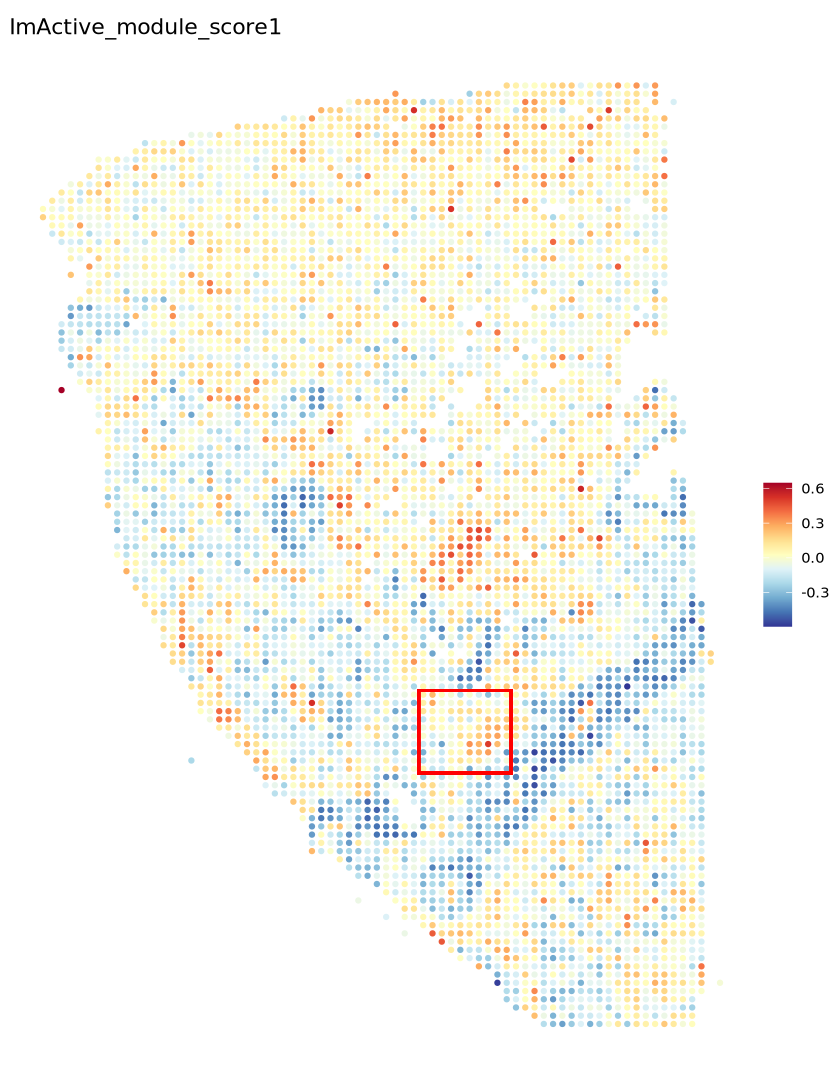

In [ ]:
library(RColorBrewer)

figsize(7, 9)

pdf(file = paste0(figdir, "/Spatial_modulescore_TLS_noBox.pdf"), width = 7, height = 9)
brewer.col <- rev(brewer.pal(11,"RdYlBu"))
FeaturePlot(obj_grid, features = "TLS_module_score1", reduction = "gridcentroid", pt.size = 1) + theme_void() + scale_colour_gradientn(colours=brewer.col) + 
        coord_flip() #+
        #geom_rect(aes(xmin = 3100, xmax = 4100, ymin = 4200, ymax = 5200), color = "red", fill = NA, linewidth = 0.8)
dev.off()

pdf(file = paste0(figdir, "/Spatial_modulescore_type1_noBox.pdf"), width = 7, height = 9)
FeaturePlot(obj_grid, features = "ImActive_module_score1", reduction = "gridcentroid", pt.size = 1) + theme_void() + scale_colour_gradientn(colours=brewer.col) + 
        coord_flip() +
        geom_rect(aes(xmin = 3100, xmax = 4100, ymin = 4200, ymax = 5200), color = "red", fill = NA, linewidth = 0.8)
dev.off()

Calculating cluster 0



Calculating cluster 1

Calculating cluster 2

Calculating cluster 3

Calculating cluster 4

Calculating cluster 5

Calculating cluster 6

Calculating cluster 7

Calculating cluster 8

Calculating cluster 9

Calculating cluster 10

Calculating cluster 11

Calculating cluster 12



p_val,avg_log2FC,pct.1,pct.2,p_val_adj,cluster,gene
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<chr>
0,2.657527,0.922,0.356,0,0,IL7R
0,2.748071,0.851,0.287,0,0,TRAC
0,2.156812,0.964,0.405,0,0,CD52
0,2.783286,0.826,0.277,0,0,TRBC1
0,2.476488,0.746,0.205,0,0,IKZF1
0,1.788775,0.867,0.343,0,0,CIITA
0,2.029957,0.904,0.389,0,0,CXCR4
0,1.541200,0.709,0.211,0,0,FYN
0,2.239271,0.748,0.257,0,0,SLAMF7


Warning message in DoHeatmap(obj_grid, features = top10$gene):
“The following features were omitted as they were not found in the scale.data slot for the RNA assay: NAMPT, YIF1B, AOC3, RNF121, PNPLA2, ITGA7, PLIN1, ACSL4, DMPK, DTNBP1, DUSP28, HIVEP2, DBN1, DLEU1, C1RL, PAK1IP1, RGPD1, MYC, S1PR3, TPBG, TNFRSF12A, YAP1, ABL2, NOC3L, EIF1B, CD93, COL4A1, PLPP3, SOCS3, FLT1, EPAS1, AP2A2, SMOX, ARRB2, CXCL16, P2RX7, MKNK1, RIPK2, DCN, CCL2, CTSL”


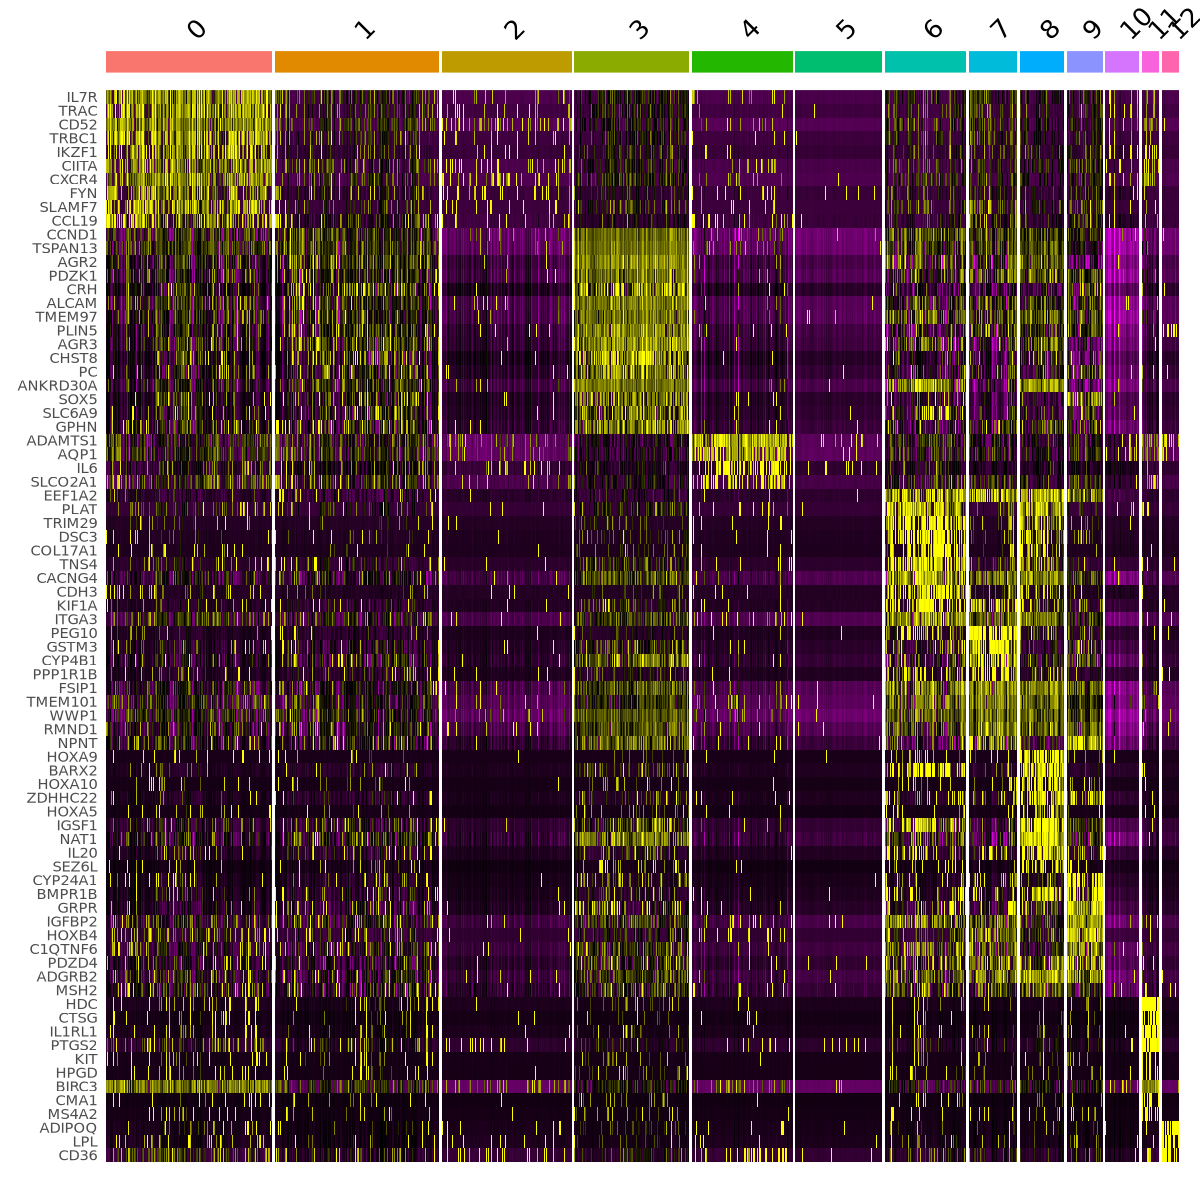

In [64]:
Idents(obj_grid) <- obj_grid$`RNA_snn_res.0.5`
obj_grid.markers <- FindAllMarkers(obj_grid, only.pos = TRUE)
obj_grid.markers %>%
    group_by(cluster) %>%
    dplyr::filter(avg_log2FC > 1)

obj_grid.markers %>%
    group_by(cluster) %>%
    dplyr::filter(avg_log2FC > 1) %>%
    slice_head(n = 10) %>%
    ungroup() -> top10

figsize(10, 10)
DoHeatmap(obj_grid, features = top10$gene) + NoLegend()

## Zoom-in high-score region

In [ ]:
# # Seurat 1.6.1 version does not support transcripts.parquet file yet. Below is the walkaround.
# # First, create cell_feature_matrix folder by unzipping tar.gz file using "tar -xvzf cell_feature_matrix.tar.gz"
# library(arrow) # -> Helps to read in .parquet file
# transcripts <- read_parquet(file.path(dir, "/data/transcripts.parquet"))
# write.csv(transcripts, gzfile(file.path(dir, "/data/transcripts.csv.gz")), row.names=FALSE)
# print("CSV Created!")

# # Create spatial object
# obj <- LoadXenium(paste0(dir, "/data"))
# SaveSeuratRds(obj, file=paste0(dir, "/xenium5k_obj.rds"))

In [ ]:
# Sam's NSCLC object did not contain image (Seurat v4), so I had to load a new object (Seurat v5) to add cell segmentation data.
obj_image <- LoadSeuratRds(paste0(dir, "/xenium5k_obj.rds"))
obj_image <- subset(obj_image, cells = obj$cell_id)
obj_image@meta.data <- obj@meta.data
rownames(obj_image@meta.data) <- as.character(obj_image$cell_id)

Warning message:
“Not validating FOV objects”
Warning message:
“Not validating Centroids objects”
Warning message:
“Not validating Centroids objects”
Warning message:
“Not validating FOV objects”
Warning message:
“Not validating Centroids objects”
Warning message:
“Not validating FOV objects”
Warning message:
“Not validating FOV objects”
Warning message:
“Not validating FOV objects”
Warning message:
“Not validating Seurat objects”


In [ ]:
# Define colors
dd.col <- rep("grey50", length(unique(obj_image$celltype_detail)))
names(dd.col) <- unique(obj_image$celltype_detail)
dd.col[names(dd.col) %in% c("T cell","B cell", "Cancer-epithelial", "Macro-Mono", "DC", "EC", "Fibroblast")] <- "grey50"
dd.col[names(dd.col) %in% unique(obj_BC$predicted.celltype)] <- '#fee500'
dd.col[names(dd.col) %in% unique(obj_TC$predicted.celltype)] <- '#FD3216'
dd.col[names(dd.col) %in% unique(obj_MM$predicted.celltype)] <- '#4af9f9'
dd.col[names(dd.col) %in% unique(obj_EC$predicted.celltype)] <- '#9800FF'
dd.col[names(dd.col) %in% unique(obj_DC$predicted.celltype)] <- '#00FF2E'

dd.col_major <- c('#fee500','#FD3216','#FF9616','#9800FF','#4af9f9','#00FF2E','#057DFF')
names(dd.col_major) <- c("B cell","T cell","NK","Macro-Mono","EC","DC","Mast cell")

# TLS.col <- c('#FD3216','#fee500','#fee500','#fee500','#4af9f9','#FD3216','#fee500','#fee500','#fee500','#62e248')
# TLS.col <- c('#FD3216','#fee500','#fee500','#fee500','#4af9f9','#fee500','#fee500','#62e248')
# names(TLS.col) <- TLS_celltypes

TLS.col_random <- c('#FD3216','#9800FF','#4af9f9','#00FFA5','#FE00CE','#FF9616','#F6F926','#00FF2E','#057DFF')
names(TLS.col_random) <- TLS_celltypes

# ImAc.col <- c('#FD3216','#62e248','#4af9f9','#4af9f9','#4af9f9','#62e248','#4af9f9','#bf72ff','#FD3216','#FD3216','#FD3216')
# names(ImAc.col) <- ImActive_celltypes

ImAc.col_random <- c('#ffb116','#00FF2E','#ededed','#9800FF','#057DFF','#0022ff','#ff6b21','#FE00CE','#FF1900','#4af9f9','#F6F926')
names(ImAc.col_random) <- ImActive_celltypes

pdf 
  2

pdf 
  2

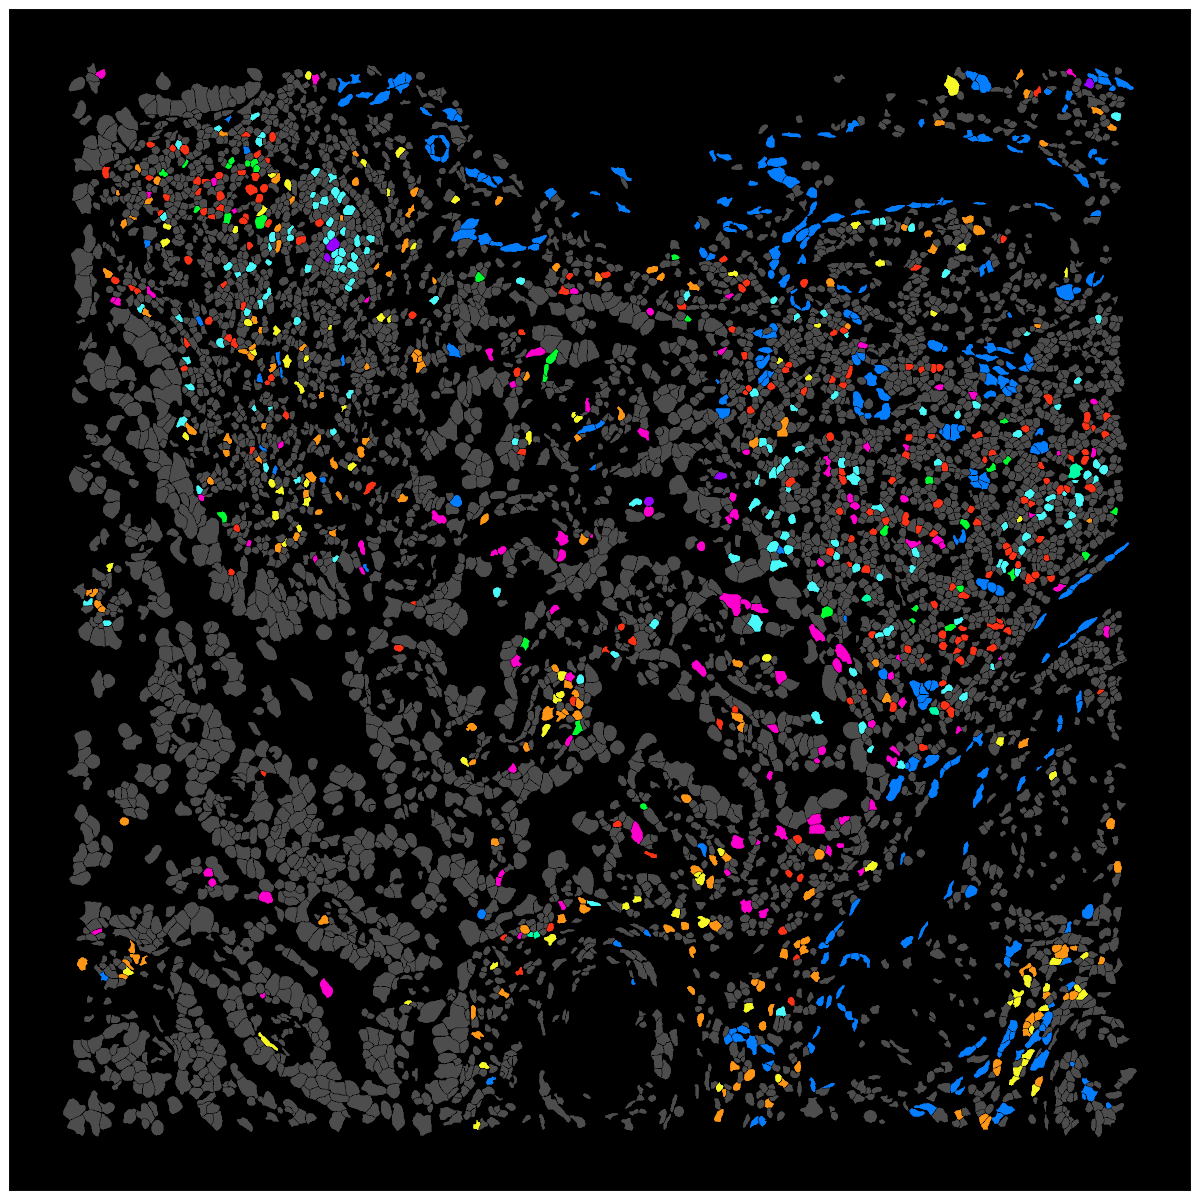

In [ ]:
# Customize FOV of the plot
options(future.globals.maxSize = 8000 * 1024^2)

cropped.coords <- Crop(obj_image[["fov"]], x = c(4200, 5200), y = c(3100, 4100), coords = "plot")
obj_image@images$tls <- cropped.coords
DefaultBoundary(obj_image@images$tls) <- "segmentation"

figsize(10,10)

pdf(file = paste0(figdir, "/zoomin_TLS_major_legend.pdf"), width = 10, height = 10)
ImageDimPlot(obj_image, fov = "tls", group.by = "celltype_major", axes = TRUE, border.color = "white", border.size = 0.1, cols = dd.col_major, na.value = "grey30", coord.fixed = FALSE) +
        theme_void()+
        theme(legend.position = "bottom",
        legend.text = element_text(color = "black", size = 10),
        legend.title = element_blank())
dev.off()

pdf(file = paste0(figdir, "/zoomin_TLS_major.pdf"), width = 10, height = 10)
ImageDimPlot(obj_image, fov = "tls", group.by = "celltype_major", axes = TRUE, border.color = "black", border.size = 0.1, cols = dd.col_major, na.value = "grey30", coord.fixed = FALSE) + 
        theme_void()+
        NoLegend() +
        theme(plot.background = element_rect(fill = "black"))
dev.off()

pdf(file = paste0(figdir, "/zoomin_TLS_subtype_legend.pdf"), width = 10, height = 10)
ImageDimPlot(obj_image, fov = "tls", group.by = "celltype_detail", axes = TRUE, border.color = "white", border.size = 0.1, cols = TLS.col_random, na.value = "grey30", coord.fixed = FALSE) +
        theme_void()+
        theme(legend.position = "bottom",
        legend.text = element_text(color = "black", size = 10),
        legend.title = element_blank())
dev.off()

pdf(file = paste0(figdir, "/zoomin_TLS_subtype.pdf"), width = 10, height = 10)
ImageDimPlot(obj_image, fov = "tls", group.by = "celltype_detail", axes = TRUE, border.color = "black", border.size = 0.1, cols = TLS.col_random, na.value = "grey30", coord.fixed = FALSE) + 
        theme_void()+
        NoLegend() +
        theme(plot.background = element_rect(fill = "black"))
dev.off()

# pdf(file = paste0(figdir, "/zoomin_TLSregion_type1_subtype.pdf"), width = 10, height = 10)
# ImageDimPlot(obj_image, fov = "tls", group.by = "celltype_detail", axes = TRUE, border.color = "black", border.size = 0.1, cols = ImAc.col_random, na.value = "grey30", coord.fixed = FALSE) + 
#         theme_void()+
#         NoLegend() +
#         theme(plot.background = element_rect(fill = "black"))
# dev.off()

# pdf(file = paste0(figdir, "/zoomin_TLSregion_type1_subtype_legend.pdf"), width = 10, height = 10)
# ImageDimPlot(obj_image, fov = "tls", group.by = "celltype_detail", axes = TRUE, border.color = "white", border.size = 0.1, cols = ImAc.col_random, na.value = "grey30", coord.fixed = FALSE) +
#         theme_void()+
#         theme(legend.position = "bottom",
#         legend.text = element_text(color = "black", size = 10),
#         legend.title = element_blank())
# dev.off()

In [ ]:
# Customize FOV of the plot
options(future.globals.maxSize = 8000 * 1024^2)

# cropped.coords <- Crop(obj_image[["fov"]], x = c(4200, 5200), y = c(5300, 6300), coords = "plot")
cropped.coords <- Crop(obj_image[["fov"]], x = c(3500, 5500), y = c(4500, 6500), coords = "plot")
obj_image@images$type1 <- cropped.coords
DefaultBoundary(obj_image@images$type1) <- "segmentation"

figsize(10,10)

pdf(file = paste0(figdir, "/zoomin_type1_major_legend.pdf"), width = 10, height = 10)
ImageDimPlot(obj_image, fov = "type1", group.by = "celltype_major", axes = TRUE, border.color = "white", border.size = 0.1, cols = dd.col_major, na.value = "grey30", coord.fixed = FALSE) +
        theme_void()+
        theme(legend.position = "bottom",
        legend.text = element_text(color = "black", size = 10),
        legend.title = element_blank())
dev.off()

pdf(file = paste0(figdir, "/zoomin_type1_major.pdf"), width = 10, height = 10)
ImageDimPlot(obj_image, fov = "type1", group.by = "celltype_major", axes = TRUE, border.color = "black", border.size = 0.1, cols = dd.col_major, na.value = "grey30", coord.fixed = FALSE) + 
        theme_void()+
        NoLegend() +
        theme(plot.background = element_rect(fill = "black"))
dev.off()

#pdf(file = paste0(figdir, "/zoomin_type1_subtype_legend.pdf"), width = 10, height = 10)
ImageDimPlot(obj_image, fov = "type1", group.by = "celltype_detail", axes = TRUE, border.color = "white", border.size = 0.1, cols = ImAc.col_random, na.value = "grey30", coord.fixed = FALSE) +
        theme_void()+
        theme(legend.position = "bottom",
        legend.text = element_text(color = "black", size = 10),
        legend.title = element_blank())
#dev.off()

#pdf(file = paste0(figdir, "/zoomin_type1_subtype.pdf"), width = 10, height = 10)
ImageDimPlot(obj_image, fov = "type1", group.by = "celltype_detail", axes = TRUE, border.color = "black", border.size = 0.1, cols = ImAc.col_random, na.value = "grey30", coord.fixed = FALSE) +
        theme_void()+
        NoLegend() +
        theme(plot.background = element_rect(fill = "black"))
#dev.off()


In [ ]:
# Bar Plot: cell type frequency 

cell_freq <- table(obj$celltype_detail)
cell_freq <- data.frame(celltype = names(cell_freq),  freq  = as.numeric(cell_freq))

cell_freq_TLS <- cell_freq[cell_freq$celltype %in% TLS_celltypes,]
cell_freq_TLS$col <- TLS.col_random[cell_freq_TLS$celltype]

cell_freq_TLS_noPCV <- cell_freq_TLS[cell_freq_TLS$celltype != "PCV",]

cell_freq_type1 <- cell_freq[cell_freq$celltype %in% ImActive_celltypes,]
cell_freq_type1$col <- ImAc.col_random[cell_freq_type1$celltype]

figsize(5, 5)

pdf(file = paste0(figdir, "/barplot_TLS.pdf"), width = 5, height = 5)
ggplot(cell_freq_TLS, aes(x = celltype, y = freq, fill = celltype)) +
  geom_bar(stat = "identity") +
  scale_fill_manual(values = TLS.col_random) +
  geom_text(aes(label = freq), vjust = 0.5, hjust = 0, angle = 90, size = 5) +
  theme_classic() +
  ylim(0, 8200) +
  theme(legend.position = "none",
          axis.text.x = element_text(size = 14, angle = 45, hjust = 1),  # Increase x-axis text size
          axis.text.y = element_text(size = 12),
          axis.title = element_blank())
dev.off()

pdf(file = paste0(figdir, "/barplot_TLS_noPCV.pdf"), width = 5, height = 5)
ggplot(cell_freq_TLS_noPCV, aes(x = celltype, y = freq, fill = celltype)) +
  geom_bar(stat = "identity") +
  scale_fill_manual(values = TLS.col_random) +
  geom_text(aes(label = freq), vjust = 0.5, hjust = 0, angle = 90, size = 5) +
  theme_classic() +
  ylim(0, 3500) +
  theme(legend.position = "none",
          axis.text.x = element_text(size = 14, angle = 45, hjust = 1),  # Increase x-axis text size
          axis.text.y = element_text(size = 12),
          axis.title = element_blank())
dev.off()

pdf(file = paste0(figdir, "/barplot_type1.pdf"), width = 5, height = 5)
ggplot(cell_freq_type1, aes(x = celltype, y = freq, fill = celltype)) +
  geom_bar(stat = "identity") +
  scale_fill_manual(values = ImAc.col_random) +
  geom_text(aes(label = freq), vjust = 0.5, hjust = 0, angle = 90, size = 5) +
  theme_classic() +
  ylim(0, 4300) +
  theme(legend.position = "none",
          axis.text.x = element_text(size = 14, angle = 45, hjust = 1),  # Increase x-axis text size
          axis.text.y = element_text(size = 12),
          axis.title = element_blank())
dev.off()

pdf 
  2

pdf 
  2

pdf 
  2